# Imports

In [98]:
import numpy as np
import pandas as pd
from tabulate import tabulate

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris, load_digits, load_breast_cancer
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, rand_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import mode
from scipy.optimize import linear_sum_assignment

plt.style.use('Solarize_Light2')

# Functions

## Normalization

In [99]:
def normalization(model, data) -> pd.DataFrame:
    # apply normalization techniques
    norm = model.fit_transform(data)
    return pd.DataFrame(data=norm, columns=data.columns)

## Map Clusters

In [100]:
def map_clusters_to_labels(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = y_pred == cluster
        labels[mask] = mode(y_true[mask], keepdims=True).mode[0]
    return labels

In [101]:
def reorder_confusion_matrix(cm):
    # Hungarian algorithm minimizes cost, so we negate to maximize diagonal
    row_ind, col_ind = linear_sum_assignment(-cm)

    # Reorder columns based on optimal assignment
    reordered_cm = cm[:, col_ind]
    return reordered_cm

## Confusion Matrix

In [102]:
def heatmap(cm_k_means, cm_db_scan, k):
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Width increases for better spacing

    # First subplot: K-Means
    sns.heatmap(cm_k_means, annot=True, fmt='d', cmap='RdPu', ax=axes[0])
    axes[0].set_xlabel('Predicted Cluster')
    axes[0].set_ylabel('True Cluster')
    axes[0].set_title('K-Means')

    # Second subplot: DBScan
    sns.heatmap(cm_db_scan[:k + 1, :], annot=True, fmt='d', cmap='RdPu', ax=axes[1])
    axes[1].set_xlabel('Predicted Cluster')
    axes[1].set_ylabel('True Cluster')
    axes[1].set_title('DB-Scan')

    plt.tight_layout()
    plt.show()

In [103]:
def confusion_matrix_heatmap(k_means_preds, y_true, db_scan_preds, y_true_db_scan, k):
  # Build confusion matrix
  cm_k_means = confusion_matrix(y_true, k_means_preds)
  cm_db_scan = confusion_matrix(y_true_db_scan, db_scan_preds)

  heatmap(cm_k_means, cm_db_scan, k)

  return (cm_k_means, cm_db_scan)

## Metrics

In [104]:
def calculate_accuracy(confusion_matrix) -> float:
    """
    Calculate accuracy from the confusion matrix.
    Accuracy is the ratio of correct predictions to total samples.

    Args:
    confusion_matrix (np.array): The confusion matrix.

    Returns:
    float: Accuracy value.
    """
    # Total correct predictions are the sum of the diagonal elements
    correct_predictions = np.trace(confusion_matrix)

    # Total samples is the sum of all elements in the confusion matrix
    total_samples = np.sum(confusion_matrix)

    # Calculate accuracy
    accuracy = correct_predictions / total_samples
    return accuracy

### Cal and Show

In [105]:
def cal_f1_score(confusion_mat):
    prf1 = []
    cm = np.array(confusion_mat)
    for i in range(cm.shape[0]):
        row_sum = np.sum(cm[i, :])
        col_sum = np.sum(cm[:, i])

        if row_sum == 0 or col_sum == 0:
            prf1.append([0, 0, 0])
            continue

        recall = cm[i, i] / row_sum
        precision = cm[i, i] / col_sum

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * recall * precision / (precision + recall)

        prf1.append(np.array([precision, recall, f1]))

    return np.array(prf1)

In [106]:
def metrics_table(method_name, prf_array, accuracy, w_precision, w_recall, w_f1):
    rows = []

    for i, (p, r, f1) in enumerate(prf_array):
        rows.append([method_name, i, f"{p:.2f}", f"{r:.2f}", f"{f1:.2f}", ""])

    # Summary row with weighted metrics
    rows.append([
        method_name, "Overall",
        f"{w_precision:.3f}", f"{w_recall:.3f}", f"{w_f1:.3f}", f"{accuracy:.2%}"
    ])

    print(tabulate(
        rows,
        headers=["Method", "Cluster", "Precision", "Recall", "F1 Score", "Accuracy"],
        tablefmt="grid"
    ))

In [107]:
def calculate_metrics(cm_kmeans, cm_dbscan):
    # Accuracy
    acc_kmeans = calculate_accuracy(cm_kmeans)
    acc_dbscan = calculate_accuracy(cm_dbscan)

    # Precision, recall, F1
    prf_kmeans = np.array(cal_f1_score(cm_kmeans))
    prf_dbscan = np.array(cal_f1_score(cm_dbscan))

    # Weighted Precision, recall, F1
    weights_k = np.sum(cm_kmeans, axis=1)
    weights_d = np.sum(cm_dbscan, axis=1)

    # Weighted Precision, Recall, F1 for K-Means
    wp_k = np.sum(prf_kmeans[:, 0] * weights_k) / np.sum(weights_k)
    wr_k = np.sum(prf_kmeans[:, 1] * weights_k) / np.sum(weights_k)
    wf1_k = np.sum(prf_kmeans[:, 2] * weights_k) / np.sum(weights_k)

    # Weighted Precision, Recall, F1 for DBSCAN
    wp_d = np.sum(prf_dbscan[:, 0] * weights_d) / np.sum(weights_d)
    wr_d = np.sum(prf_dbscan[:, 1] * weights_d) / np.sum(weights_d)
    wf1_d = np.sum(prf_dbscan[:, 2] * weights_d) / np.sum(weights_d)

    metrics_table("K-Means", prf_kmeans, acc_kmeans, wp_k, wr_k, wf1_k)
    print("\n\n")
    metrics_table("DBSCAN", prf_dbscan, acc_dbscan, wp_d, wr_d, wf1_d)

In [108]:
def calculate_clustering_metrics(method_name, X_valid, labels_valid):
    silhouette = silhouette_score(X_valid, labels_valid)
    db_index = davies_bouldin_score(X_valid, labels_valid)
    ch_index = calinski_harabasz_score(X_valid, labels_valid)

    print(f"\nClustering Evaluation Metrics ({method_name}):")
    print(f"Silhouette Score(H)      : {silhouette:.4f}")
    print(f"Davies–Bouldin Index(L)    : {db_index:.4f}")
    print(f"Calinski–Harabasz Index(H) : {ch_index:.4f}")

# Main

In [109]:
def main(X: pd.DataFrame, y_true: np.array, k: int, eps: float, norm_model):
    # Normalize X
    X_norm = normalization(norm_model(), X)

    # Perform KMeans and DBScan clustering
    kmeans = KMeans(n_clusters=k)
    y_pred_k_means = kmeans.fit_predict(X_norm)

    dbscan = DBSCAN(eps=eps)
    y_pred_db_scan = dbscan.fit_predict(X_norm)

    # new versions of y_preds
    k_means_labels = map_clusters_to_labels(y_true, y_pred_k_means)

    # remove noises
    dbscan_core_pred = y_pred_db_scan[y_pred_db_scan != -1]
    dbscan_core_true = y_true[y_pred_db_scan != -1]

    db_scan_labels = map_clusters_to_labels(dbscan_core_true, dbscan_core_pred)

    # map clusters and create confusion matrix
    _ = confusion_matrix_heatmap(y_pred_k_means, y_true, y_pred_db_scan, y_true, k)
    cm_k_means, cm_db_scan = confusion_matrix_heatmap(k_means_labels, y_true, db_scan_labels, dbscan_core_true, k)

    calculate_metrics(cm_k_means, cm_db_scan)

    calculate_clustering_metrics("K-Means", X_norm.copy(), y_pred_k_means)
    calculate_clustering_metrics("DBSCAN", X_norm[y_pred_db_scan != -1].copy(), dbscan_core_pred)

# Load Dataset and Run Main

>Silhouette → cohesion vs. separation (closer to 1 is better)

>Davies–Bouldin → lower is better

>Calinski–Harabasz → higher is better

## Iris

In [110]:
X1, y1 = load_iris(return_X_y=True, as_frame=True)

### All Columns

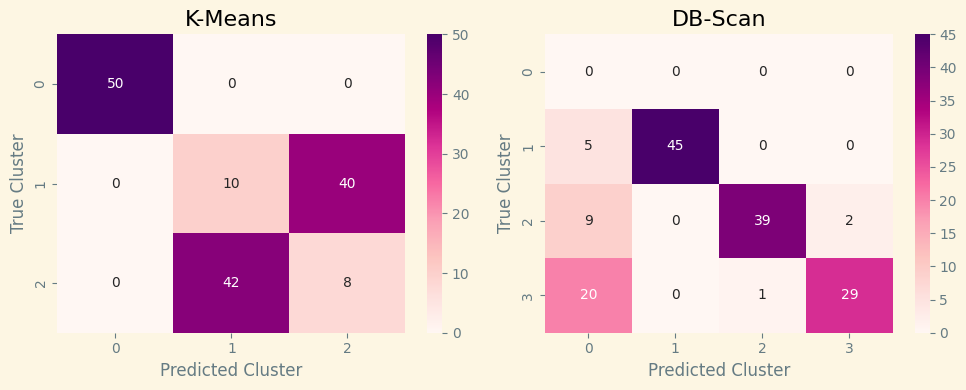

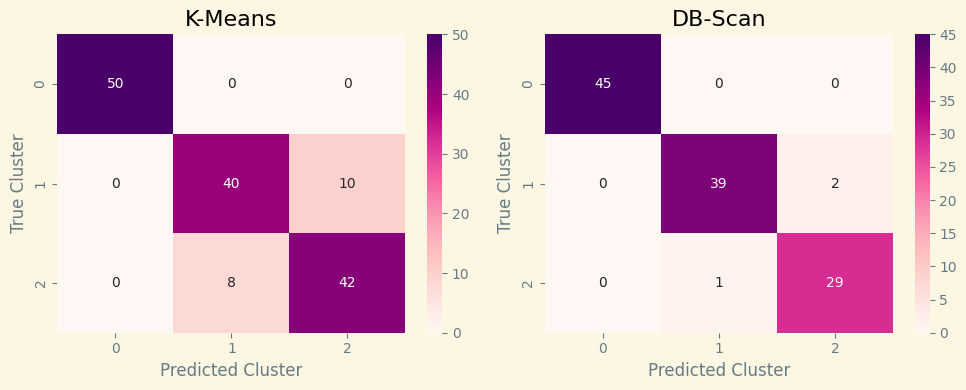

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |        1    |     1    |       1    |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |        0.83 |     0.8  |       0.82 |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 2         |        0.81 |     0.84 |       0.82 |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |        0.88 |     0.88 |       0.88 | 88.00%     |
+----------+-----------+-------------+----------+------------+------------+



+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+========

In [111]:
main(X=X1, y_true=y1.to_numpy(), k=len(np.unique(y1)), eps=0.128, norm_model=MinMaxScaler)

### Selected Columns

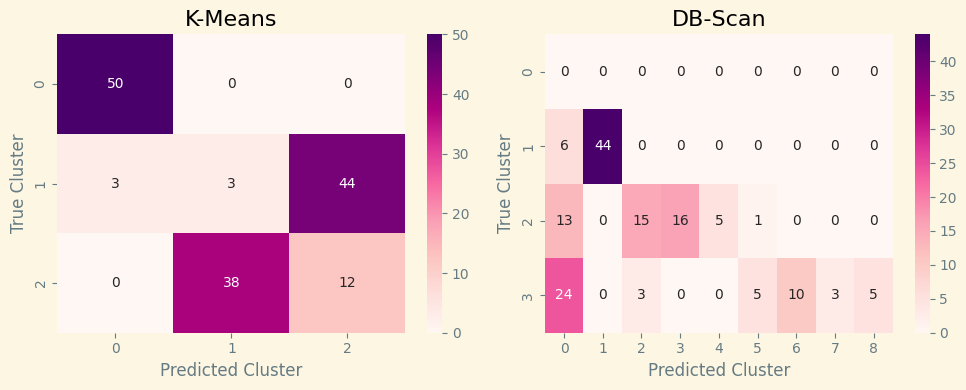

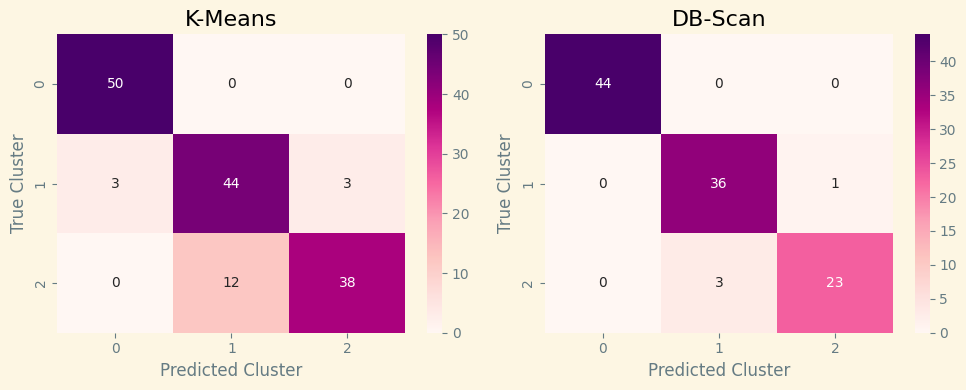

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       0.94  |     1    |      0.97  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.79  |     0.88 |      0.83  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 2         |       0.93  |     0.76 |      0.84  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |       0.885 |     0.88 |      0.879 | 88.00%     |
+----------+-----------+-------------+----------+------------+------------+



+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+========

In [112]:
main(X=X1.iloc[:, [0, 3]], y_true=y1.to_numpy(), k=len(np.unique(y1)), eps=0.0525, norm_model=MinMaxScaler)

## Breast Cancer

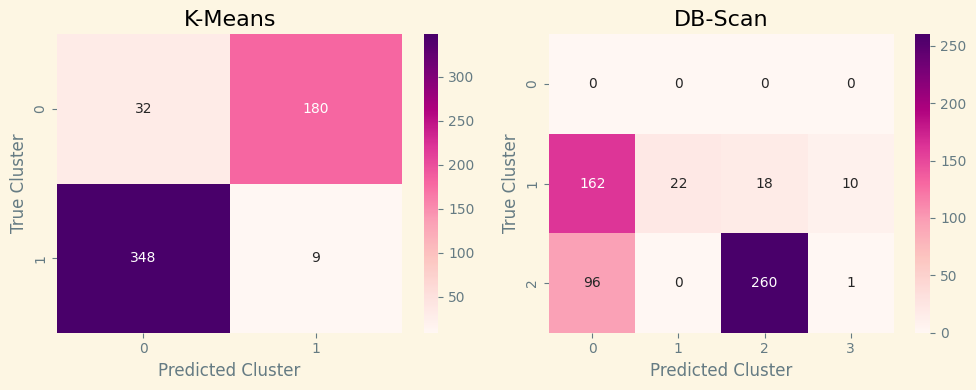

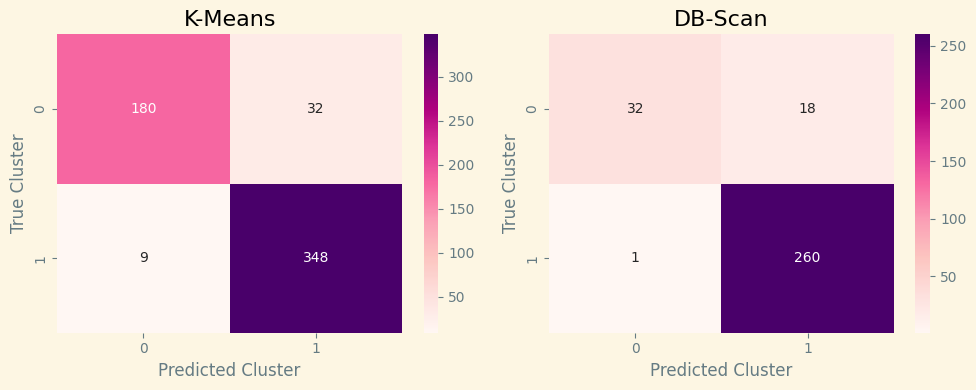

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       0.95  |    0.85  |      0.9   |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.92  |    0.97  |      0.94  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |       0.929 |    0.928 |      0.927 | 92.79%     |
+----------+-----------+-------------+----------+------------+------------+



+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| DBSCAN   | 0         |       0.97  |    0.64  |      0.77  |            |
+--------

In [113]:
X1, y1 = load_breast_cancer(return_X_y=True, as_frame=True)

main(X=X1, y_true=y1.to_numpy(), k=len(np.unique(y1)), eps=0.325, norm_model=MinMaxScaler)

## Digits

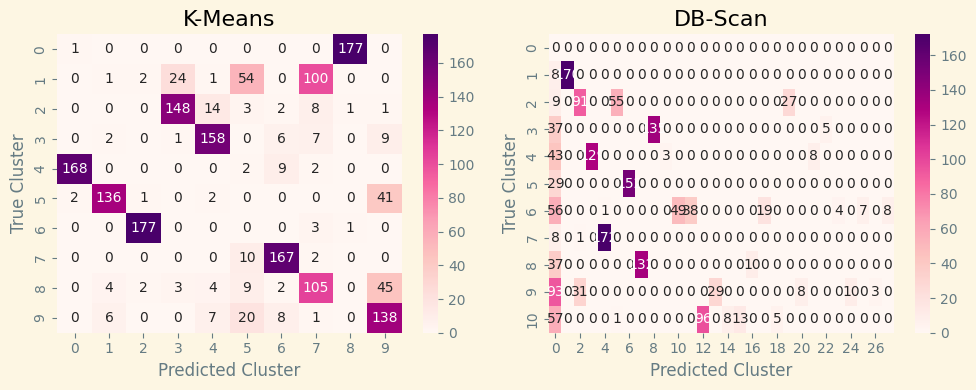

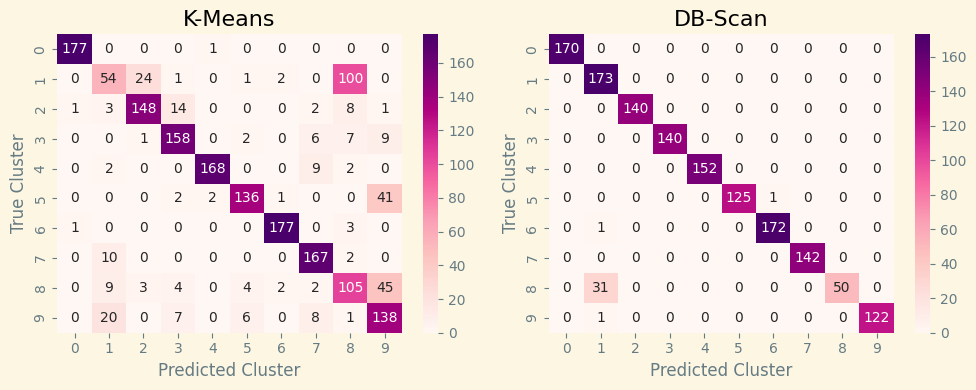

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       0.99  |    0.99  |      0.99  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.55  |    0.3   |      0.39  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 2         |       0.84  |    0.84  |      0.84  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 3         |       0.85  |    0.86  |      0.86  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 4         |       0.98  |    0.93  |      0.95  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  |

In [114]:
X1, y1 = load_digits(return_X_y=True, as_frame=True)

main(X=X1, y_true=y1.to_numpy(), k=len(np.unique(y1)), eps=1.3, norm_model=MinMaxScaler)

It could be overfitting or misleading if:

    You tuned DBSCAN’s parameters (eps, min_samples) based on label performance, which breaks the unsupervised principle and leads to overfitting to the labels.

    DBSCAN found many tiny or noisy clusters that perfectly matched some small parts of the labeled data — this might look good but doesn’t generalize.

    Some clusters may correspond to very few samples, which artificially boosts metrics.